In [12]:
import re
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import numpy as np
import pandas as pd
import seaborn as sns     
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = [8, 5]
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

pd.set_option('display.max_columns', 20)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [125]:
df=pd.read_csv('data.csv', index_col= 0)
df.sample(5)

,pair_id,id_1,id_2,text_1,text_2,is_paraphrase
6877,25084,34052,34051,Рособоронэкспорт планирует расширить поставки ...,"""Рособоронэкспорт"" расширит поставки вооружени...",0
6261,24421,33085,33086,Американская миссия на Украине,The Economist: миссия военных США на Украине -...,-1
5492,7165,32248,32243,Предполагаемый исполнитель убийства Немцова за...,Суд продлил арест предполагаемому исполнителю ...,-1
3668,3979,3278,7344,Walt Disney откроет в России фирменные магазины.,В России откроются магазины Walt Disney.,1
4513,4883,4067,8088,Delta Airlines из-за технического сбоя устроил...,Американская авиакомпания случайно устроила ра...,0


In [126]:
predictors = df.copy(deep=True)
target = predictors.pop('is_paraphrase')
predictors.head()

,pair_id,id_1,id_2,text_1,text_2
0,1,201,8159,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...
1,2,202,8158,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...
2,3,273,8167,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...
3,4,220,8160,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...
4,5,223,8160,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...


In [ ]:
target_lst = target.tolist()

# Preprocessing

remove unnecessary symbols, apply lower register

In [127]:
def clean_text(text):
    cleaned_text = []
    punctuation = """–!()[]{};?@#:'"\,./^&amp;*_-«»`"""
    text = text.lower()
    tokenized_text = word_tokenize(text)
    cleaned_text.extend([token for token in tokenized_text if token not in punctuation])
    return  ' '.join(cleaned_text)

In [128]:
predictors["text_1"] = predictors["text_1"].apply(lambda x:clean_text(x))
predictors["text_2"] = predictors["text_2"].apply(lambda x:clean_text(x))

In [129]:
predictors.head()

,pair_id,id_1,id_2,text_1,text_2
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии


In [130]:
# make lists for other functions 

text_1 = predictors["text_1"].tolist()
text_2 = predictors["text_2"].tolist()

pairs_paraphrase = (list(zip(text_1, text_2)))

## Lemmatization

In [15]:
lemmatized_df = predictors.copy(deep=True)

In [16]:
def lemmatize(text):
    parsed_text = []
    tokens = text.split()
    parsed_text.extend([morph.parse(token)[0].normal_form for token in tokens])
    return ' '.join(parsed_text)

In [17]:
lemmatized_df["text_1"] = lemmatized_df["text_1"].apply(lambda x:lemmatize(x))
lemmatized_df["text_2"] = lemmatized_df["text_2"].apply(lambda x:lemmatize(x))

In [18]:
lemmatized_df.head()

,pair_id,id_1,id_2,text_1,text_2
0,1,201,8159,полицейский разрешить стрелять на поражение по...,полиция мочь разрешить стрелять по хулиган с т...
1,2,202,8158,право полицейский на проникновение в жилище ре...,правило внесудебный проникновение полицейский ...
2,3,273,8167,президент египет ввести чрезвычайный положение...,власть египет угрожать ввести в страна чрезвыч...
3,4,220,8160,вернуться из сирия россиянин волновать вопрос ...,самолёт мчс вывезти россиянин из разрушить сирия
4,5,223,8160,в москва из сирия вернуться 2 самолёт мчс с ро...,самолёт мчс вывезти россиянин из разрушить сирия


In [19]:
# save lemmatized dataset
#lemmatized_df.to_csv('data_lemm.csv')

In [21]:
# make lists for other functions
text_1_lem = lemmatized_df["text_1"].tolist()
text_2_lem = lemmatized_df["text_2"].tolist()

pairs_paraphrase_lem = list(zip(text_1_lem, text_2_lem))

# Semantic similarity metrics

## Jaccard distance

In [139]:
def get_jaccard_sim(pairs): 
    jaccard_lst = []
    for pair in pairs:
      tokens1 = set(pair[0].split()) 
      tokens2 = set(pair[1].split())
      intersection_ = tokens1.intersection(tokens2)
      jaccard_ = float(len(intersection_)) / (len(tokens1) + len(tokens2) - len(intersection_))
      jaccard_lst.append(jaccard_)
    return jaccard_lst

jaccard_sim_lem = get_jaccard_sim(pairs_paraphrase_lem)

In [140]:
predictors['jaccard_sim'] = jaccard_sim_lem
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143


## Levenshtein distance

In [ ]:
#!pip install fuzzywuzzy

In [ ]:
#!pip install python-Levenshtein

In [141]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [142]:
def get_lev_dist(pairs): 
    lev_lst = []
    for pair in pairs:
      lev_ = fuzz.token_sort_ratio(pair[0], pair[1])
      lev_lst.append(lev_)
    return lev_lst

lev_dist = get_lev_dist(pairs_paraphrase)

In [143]:
predictors['levenshtein'] = lev_dist
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62


# Lexic transformations

## Synonyms

In [ ]:
#!pip install wiki-ru-wordnet

In [87]:
from wiki_ru_wordnet import WikiWordnet
wikiwordnet = WikiWordnet()

In [167]:
def find_synonyms(pairs): 
    syn_lst = []
    for pair in pairs:
      syn = 0
      tokens1 = pair[0].split()
      tokens2 = pair[1].split()
      synsets = wikiwordnet.get_synsets(tokens1[0])
      for token in tokens1:
        synsets = wikiwordnet.get_synsets(token)
        if len(synsets) != 0:
          synset1 = synsets[0]
          synonyms = [w.lemma() for w in synset1.get_words()]
          for synonym in synonyms:
            if synonym in tokens2:
              syn += 1
      syn_lst.append(syn)
    return syn_lst

synonyms = find_synonyms(pairs_paraphrase_lem)

In [168]:
predictors['synonym'] = synonyms
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3


In [ ]:
predictors['synonyms'] = synonyms
predictors.head()

,id,id_1,id_2,text_1,text_2,jaccard_sim,synonyms
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,0
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,0
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,1
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,0
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,0


## Hyponyms

In [181]:
def find_hyponym(pairs): 
    hyp_lst = []
    for pair in pairs:
      hyp = 0
      tokens1 = pair[0].split()
      tokens2 = pair[1].split()
      synsets = wikiwordnet.get_synsets(tokens1[0])
      for token in tokens1:
        synsets = wikiwordnet.get_synsets(token)
        if len(synsets) != 0:
          synset1 = synsets[0]
          for hyponym in wikiwordnet.get_hyponyms(synset1):
            hyponyms = [w.lemma() for w in synset1.get_words()]
            for item in hyponyms:
              if item in tokens2:
                hyp += 1
      hyp_lst.append(hyp)
    return hyp_lst

hyponyms = find_hyponym(pairs_paraphrase_lem)

In [182]:
predictors['hyponyms'] = hyponyms
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym,hyponyms
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4,2
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3,46
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3,32
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2,0
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3,11


## Hypernyms

In [184]:
def find_hypernym(pairs): 
    hyper_lst = []
    for pair in pairs:
      hyper = 0
      tokens1 = pair[0].split()
      tokens2 = pair[1].split()
      synsets = wikiwordnet.get_synsets(tokens1[0])
      for token in tokens1:
        synsets = wikiwordnet.get_synsets(token)
        if len(synsets) != 0:
          synset1 = synsets[0]
          for hypernym in wikiwordnet.get_hypernyms(synset1):
            hypernyms = [w.lemma() for w in synset1.get_words()]
            for item in hypernyms:
              if item in tokens2:
                hyper += 1
      hyper_lst.append(hyper)
    return hyper_lst

hypernyms = find_hypernym(pairs_paraphrase_lem)

In [185]:
predictors['hypernyms'] = hypernyms
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym,hyponyms,hypernyms
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4,2,0
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3,46,5
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3,32,1
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2,0,2
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3,11,4


## Symbols

In [245]:
def find_symbol(pairs): 
    symbol_lst = []
    for pair in pairs:
      symbol = 0
      tokens1 = pair[0].split()
      tokens2 = pair[1].split()

      # percentage
      percentage = re.compile('процент\w+')
      per_symb = re.compile('%')
      if (len(per_symb.findall(pair[0])) != 0) and (len(percentage.findall(pair[1])) != 0):
        symbol += 1
      if (len(per_symb.findall(pair[1])) != 0) and (len(percentage.findall(pair[0])) != 0):
        symbol += 1
      
      # currency
      euro_symb = re.compile('€')
      euro = re.compile('евро')
      if (len(euro_symb.findall(pair[0])) != 0) and (len(euro.findall(pair[1])) != 0):
        symbol += 1
      if (len(euro_symb.findall(pair[1])) != 0) and (len(euro.findall(pair[0])) != 0):
        symbol += 1

      rub_symb = re.compile('₽')
      rub = re.compile('рубл\w+')
      if (len(rub_symb.findall(pair[0])) != 0) and (len(rub.findall(pair[1])) != 0):
        symbol += 1
      if (len(rub_symb.findall(pair[1])) != 0) and (len(rub.findall(pair[0])) != 0):
        symbol += 1

      dollar_symb = re.compile('$')
      dollar = re.compile('дол?лар\w+')
      if (len(dollar_symb.findall(pair[0])) != 0) and (len(dollar.findall(pair[1])) != 0):
        symbol += 1
      if (len(dollar_symb.findall(pair[1])) != 0) and (len(dollar.findall(pair[0])) != 0):
        symbol += 1

      
      symbol_lst.append(symbol)
    return symbol_lst

symbols = find_symbol(pairs_paraphrase)

In [248]:
predictors['symbols'] = symbols
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym,hyponyms,hypernyms,symbols
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4,2,0,0
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3,46,5,0
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3,32,1,0
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2,0,2,0
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3,11,4,0


### Numerals

In [250]:
def find_numbers(pairs, numbers_file): 
    num_dict = {}
    nums_labels = []
    with open(numbers_file, encoding='utf-8') as file:
        for line in file:
            key, *value = line.split()
            num_dict[key] = value
    for pair in pairs:
        nums = 0
        tokens1 = set(pair[0].split()) 
        tokens2 = set(pair[1].split())
        k = 0
        for word in tokens1:
            if word.isdigit():
                k = 1
                break
        for word in tokens2:
            if word.isdigit():
                k = 1
                break
        
        if k == 1:
            for word_0 in tokens1:
                for word_1 in tokens2: 
                    if word_0 in num_dict.keys() and word_1 in num_dict[word_0]:
                        nums = 1  
                    elif word_1 in num_dict.keys() and word_0 in num_dict[word_1]:
                        nums = 1
            if nums == 1:
                nums_labels.append(1)
            else:
                nums_labels.append(0)
        
        else:
            nums_labels.append(0)

    return nums_labels

numerals = find_numbers(pairs_paraphrase_lem, 'numbers.txt')

In [252]:
predictors['numerals'] = numerals
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym,hyponyms,hypernyms,symbols,numerals
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4,2,0,0,0
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3,46,5,0,0
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3,32,1,0,0
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2,0,2,0,0
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3,11,4,0,0


## Short forms

In [258]:
def find_short_forms(pairs, short_forms_file): 
    short_forms_dict = {}
    short_forms_labels = []
    with open(short_forms_file, encoding='utf-8') as file:
        for line in file:
            key, *value = line.split()
            short_forms_dict[key] = value
    for pair in pairs:
        short_forms = 0
        tokens1 = set(pair[0].split()) 
        tokens2 = set(pair[1].split())
        for word_0 in tokens1:
            for word_1 in tokens2: 
                if word_0 in short_forms_dict.keys() and word_1 in short_forms_dict[word_0]:
                    short_forms = 1  
                elif word_1 in short_forms_dict.keys() and word_0 in short_forms_dict[word_1]:
                    short_forms = 1
        if short_forms == 1:
            short_forms_labels.append(1)
        else:
            short_forms_labels.append(0)
    return short_forms_labels

short_form = find_short_forms(pairs_paraphrase_lem, 'short_forms.txt')

In [259]:
predictors['short_form'] = short_form
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym,hyponyms,hypernyms,symbols,numerals,voice_change,inversion,short_form
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4,2,0,0,0,0,0,0
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3,46,5,0,0,0,0,0
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3,32,1,0,0,0,0,0
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2,0,2,0,0,0,0,0
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3,11,4,0,0,0,0,0


In [ ]:
predictors['abbreviation'] = abbreviations
predictors.head()

## Syntactic transformations

## Voice change

In [254]:
def compare_voice(pairs): 
    voice_labels = []
    
    count1 = 0
    count2 = 0
    
    tags_tokens1 = []
    tags_tokens2 = []
    
    lemmatized1 = []
    lemmatized2 = []
    
    for pair in pairs:
        tokens1 = pair[0].split()
        for token in tokens1:
            p = morph.parse(token)[0]
            tags_tokens1.append(p.tag.voice)
            lemmatized1.append(p.normal_form)
        scheme1 = list(zip(lemmatized1, tags_tokens1))
        
        tokens2 = pair[1].split()
        for token in tokens2:
            p = morph.parse(token)[0]
            tags_tokens2.append(p.tag.voice)
            lemmatized2.append(p.normal_form)
        scheme2 = list(zip(lemmatized2, tags_tokens2))
        
        for i in scheme1:
            if i[1] == 'pssv':
                lemma = i[0]
            else:
                lemma = ''
        
        for i in scheme2: 
            if i[0] == lemma:
                count1 += 1
                #print('Active voice paraphrase found')
        
        for i in scheme2:
            if i[1] == 'pssv':
                lemma = i[0]
            else:
                lemma = ''
        
        for i in scheme1: 
            if i[0] == lemma:
                count2 += 1
                #print('Passive voice paraphrase found')
                
                
        if count1 or count2 > 0:
            voice_labels.append(1)
        else: 
            voice_labels.append(0)
    
    return voice_labels

voice_change = compare_voice(pairs_paraphrase)

In [255]:
predictors['voice_change'] = voice_change
predictors.head()

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym,hyponyms,hypernyms,symbols,numerals,voice_change
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4,2,0,0,0,0
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3,46,5,0,0,0
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3,32,1,0,0,0
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2,0,2,0,0,0
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3,11,4,0,0,0


## Inversion

In [256]:
def compare_inverse(pairs):
    inversion_labels = []
    
    count1 = 0
    count2 = 0
    
    tags_tokens1 = []
    tags_tokens2 = []
    
    lemmatized1 = []
    lemmatized2 = []
    
    for pair in pairs:
        tokens1 = pair[0].split()
        for token in tokens1:
            p = morph.parse(token)[0]
            tags_tokens1.append(p.tag.POS)
            lemmatized1.append(p.normal_form)
        scheme1 = list(zip(lemmatized1, tags_tokens1))
        
        tokens2 = pair[1].split()
        for token in tokens2:
            p = morph.parse(token)[0]
            tags_tokens2.append(p.tag.POS)
            lemmatized2.append(p.normal_form)
        scheme2 = list(zip(lemmatized2, tags_tokens2))
        
        for i in range(len(scheme1)-1): 
            if (scheme1[i][1] == 'NPRO' or scheme1[i][1] == 'NOUN') and scheme1[i+1][1] == 'VERB':
                lemma_noun = scheme1[i][0]
                lemma_verb = scheme1[i+1][0]
            else:
                lemma_noun = ''
                lemma_verb = ''
        
        for i in range(len(scheme2)-1): 
            if scheme2[i][0] == lemma_verb and scheme2[i+1][0] == lemma_noun:
                count1 += 1
                #print('Inversion Verb-Subject paraphrase found')
        
        for i in range(len(scheme2)-1): 
            if (scheme2[i][1] == 'NPRO' or scheme2[i][1] == 'NOUN') and scheme2[i+1][1] == 'VERB':
                lemma_noun = scheme2[i][0]
                lemma_verb = scheme2[i+1][0]
            else:
                lemma_noun = ''
                lemma_verb = ''
        
        for i in range(len(scheme1)-1): 
            if scheme1[i][0] == lemma_verb and scheme1[i+1][0] == lemma_noun:
                count2 += 1
                #print('Inversion Subject-Verb paraphrase found')
                
                
        if count1 or count2 > 0:
            inversion_labels.append(1)
        else: 
            inversion_labels.append(0)
    
    return inversion_labels

inversion = compare_inverse(pairs_paraphrase)

Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Subject-Verb paraphrase found
Inversion Subject-Verb paraphrase found
Inversion Subject-Verb paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found
Inversion Verb-Subject paraphrase found


In [257]:
predictors['inversion'] = inversion
predictors.head(10)

,pair_id,id_1,id_2,text_1,text_2,jaccard_sim,levenshtein,synonym,hyponyms,hypernyms,symbols,numerals,voice_change,inversion
0,1,201,8159,полицейским разрешат стрелять на поражение по ...,полиции могут разрешить стрелять по хулиганам ...,0.416667,67,4,2,0,0,0,0,0
1,2,202,8158,право полицейских на проникновение в жилище ре...,правила внесудебного проникновения полицейских...,0.363636,63,3,46,5,0,0,0,0
2,3,273,8167,президент египта ввел чрезвычайное положение в...,власти египта угрожают ввести в стране чрезвыч...,0.454545,66,3,32,1,0,0,0,0
3,4,220,8160,вернувшихся из сирии россиян волнует вопрос тр...,самолеты мчс вывезут россиян из разрушенной сирии,0.230769,42,2,0,2,0,0,0,0
4,5,223,8160,в москву из сирии вернулись 2 самолета мчс с р...,самолеты мчс вывезут россиян из разрушенной сирии,0.357143,62,3,11,4,0,0,0,0
5,6,154,8153,приставы соберут отпечатки пальцев российских ...,приставы снимут отпечатки пальцев у злостных н...,0.300000,67,2,12,1,0,0,0,0
6,7,288,8170,на саратовского дебошира с борта самолета моск...,саратовский дебошир отказывается возвращаться ...,0.133333,50,1,0,0,0,0,0,0
7,8,237,8163,цик хочет отказаться от электронной системы по...,цик может отказаться от электронных средств по...,0.600000,80,4,5,0,0,0,0,0
8,9,192,8156,суд петербурга оставил на потом дело о гибели ...,лондонский гайд-парк это не место для митингов...,0.000000,38,0,0,0,0,0,0,0
9,10,127,8149,страны опек сократили добычу нефти на 1 млн ба...,обама продлил полномочия наса по сотрудничеств...,0.000000,36,0,0,0,0,0,0,0


## Training and testing the model

In [266]:
features = predictors.drop(['pair_id'], axis = 1)
features = features.drop(['id_1'], axis = 1)
features = features.drop(['id_2'], axis = 1)

In [267]:
features.head()

,jaccard_sim,levenshtein,synonym,hyponyms,hypernyms,symbols,numerals,voice_change,inversion,short_form
0,0.416667,67,4,2,0,0,0,0,0,0
1,0.363636,63,3,46,5,0,0,0,0,0
2,0.454545,66,3,32,1,0,0,0,0,0
3,0.230769,42,2,0,2,0,0,0,0,0
4,0.357143,62,3,11,4,0,0,0,0,0


In [272]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [270]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Logistic regression

In [286]:
lr = LogisticRegression(random_state=42)

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('logistic', lr)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.72      0.68      0.70       522
           0       0.53      0.66      0.59       588
           1       0.60      0.38      0.47       336

    accuracy                           0.61      1446
   macro avg       0.62      0.58      0.59      1446
weighted avg       0.62      0.61      0.60      1446



In [274]:
def plot_coef(model_coeff, df, figsize=(25, 12), num_feat=150):
    
    coef_arr = np.abs(model_coeff).sum(axis=0)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)

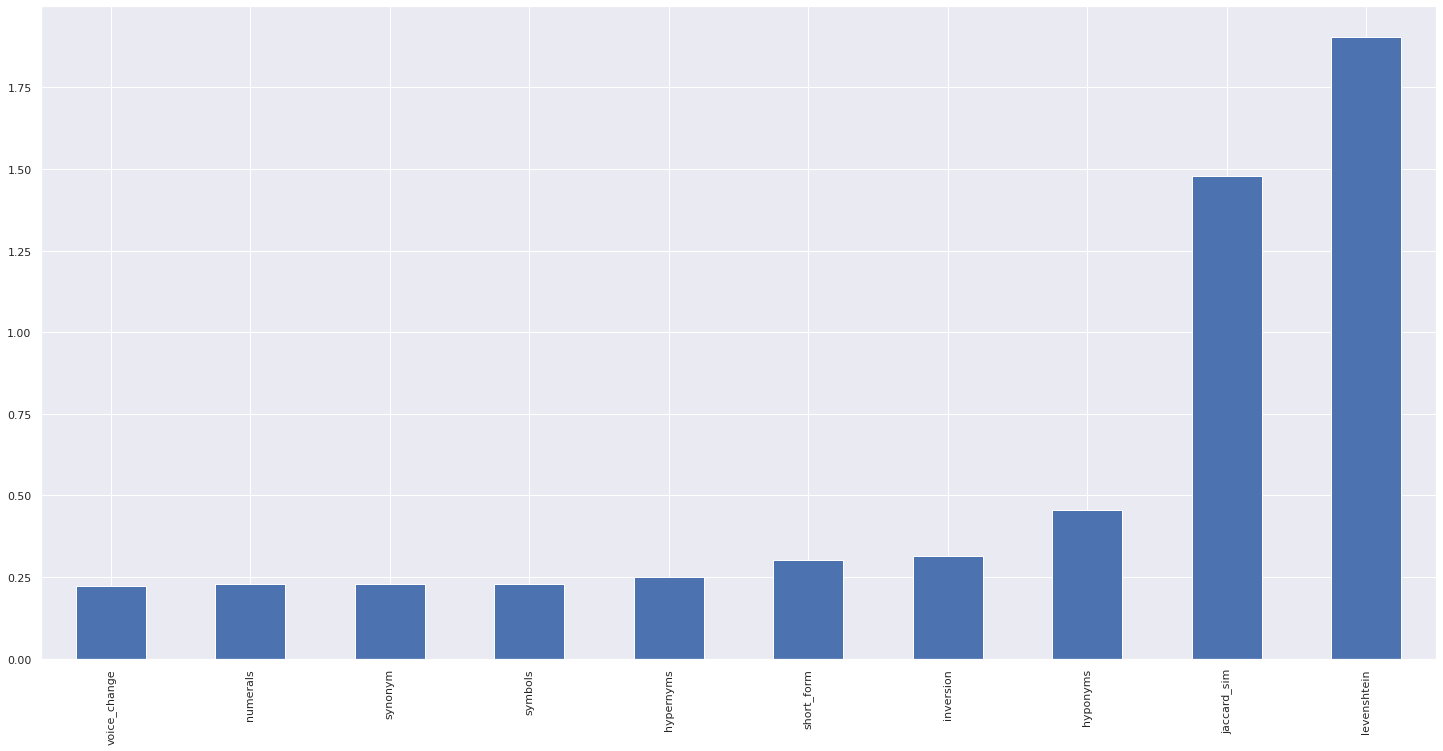

In [276]:
plot_coef(lr.coef_, features)

In [277]:
y_pred = pipe.predict(X_test)

                     precision    recall  f1-score   support

     paraphrase (1)       0.73      0.71      0.72       515
non-paraphrase (-1)       0.57      0.65      0.61       608
 semi-paraphrase(0)       0.59      0.45      0.51       323

           accuracy                           0.63      1446
          macro avg       0.63      0.61      0.61      1446
       weighted avg       0.63      0.63      0.63      1446



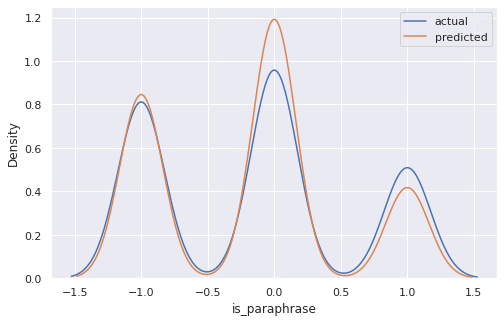

In [278]:
target_names = ['paraphrase (1)', 'non-paraphrase (-1)', 'semi-paraphrase(0)']
print(classification_report(y_test, y_pred, target_names=target_names))

sns.distplot(y_test, bins=100, hist=False, label='actual')
sns.distplot(y_pred, bins=100, hist=False, label='predicted')
plt.legend()
plt.show()

## Random Forest

In [285]:
rf = RandomForestClassifier()
pipe_rf = Pipeline(steps=[('scaler', StandardScaler()), 
                           ('random_forest', rf)])

pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.69      0.68      0.68       522
           0       0.50      0.57      0.53       588
           1       0.49      0.39      0.43       336

    accuracy                           0.57      1446
   macro avg       0.56      0.54      0.55      1446
weighted avg       0.57      0.57      0.56      1446



## KNeighbors classifier

In [279]:
from sklearn.neighbors import KNeighborsClassifier

In [280]:
n3 = KNeighborsClassifier(n_neighbors=3)
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('knn', n3)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.70      0.65       522
           0       0.51      0.49      0.50       588
           1       0.50      0.40      0.44       336

    accuracy                           0.55      1446
   macro avg       0.54      0.53      0.53      1446
weighted avg       0.54      0.55      0.54      1446



## GaussianNB

In [281]:
from sklearn.naive_bayes import GaussianNB

In [282]:
GNB = GaussianNB()
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('GNB', GNB)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.40      0.95      0.56       522
           0       0.40      0.05      0.09       588
           1       0.62      0.22      0.33       336

    accuracy                           0.42      1446
   macro avg       0.47      0.41      0.33      1446
weighted avg       0.45      0.42      0.32      1446



## SVC

In [283]:
from sklearn import svm

In [284]:
svc = svm.SVC()
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('svc', svc)])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.76      0.61      0.68       522
           0       0.51      0.75      0.60       588
           1       0.62      0.29      0.40       336

    accuracy                           0.59      1446
   macro avg       0.63      0.55      0.56      1446
weighted avg       0.63      0.59      0.58      1446

